## Query processing flowchart
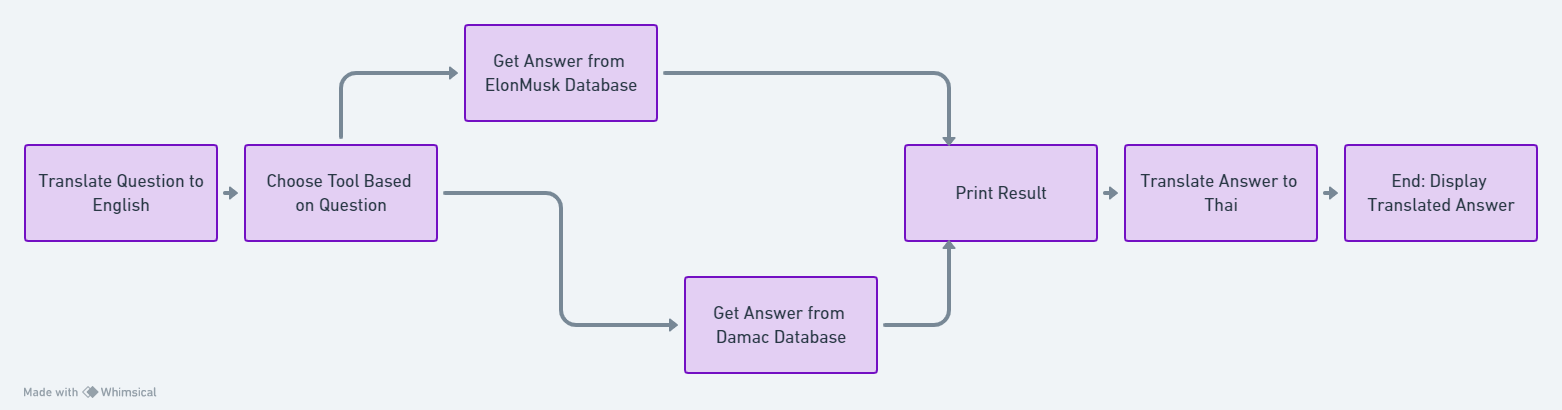

In [2]:
import os
import tiktoken 
from typing import Union, List
from dotenv import load_dotenv
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA, LLMChain
from langchain import OpenAI, PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.agents import tool
from langchain.prompts import PromptTemplate
from langchain.schema import AgentAction, AgentFinish
from langchain.tools import Tool
from langchain.tools.render import render_text_description
from langchain.agents.output_parsers import ReActSingleInputOutputParser
from langchain.agents.format_scratchpad import format_log_to_str
from tools.callbacks import AgentCallbackHandler

#load variable from .env
load_dotenv()  
openai_api_key = os.getenv('OPENAI_API_KEY')

### Ingestion

In [2]:
# loader = PyPDFLoader(file_path=pdf_path)
# documents = loader.load()
# text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=30, separator="\n")
# chunked_docs = text_splitter.split_documents(documents=documents)
# # Count the chunks
# num_chunks = len(chunked_docs)
# embeddings = OpenAIEmbeddings()
# vectorstores = FAISS.from_documents(chunked_docs, embeddings)
# vectorstores.save_local("damac_database")
# damac_vectorstore = FAISS.load_local("damac_database", embeddings)

### Prompflow

In [3]:
#assign variables
Question = """
        วัตถุประงสงของพื้นที่ที่ผู้เช่าจะเช่าจะเอาไปทำอะไร
        """
input_language = 'TH'
output_language = 'EN'

#promptTemplate
summary_templates = """
   You are a translation specialist with 35 years of experience in translating from {input_language} to {output_language}. Given the question {Question}, 
   your task is to translate it into {output_language}. If the question is already in {output_language}, check for any grammatical mistakes and correct them if necessary.
    Caution:
    Provide only the answer, without any explanations.
    """

summary_prompts_template = PromptTemplate(input_variables=['Question','input_language','output_language'], template = summary_templates)

llm = ChatOpenAI(temperature= 0, model_name="gpt-4",api_key=openai_api_key)

chain = LLMChain(llm=llm, prompt=summary_prompts_template) 

Question = chain.run(Question=Question,input_language=input_language,output_language=output_language)

print(Question)  

What is the purpose of the area that the tenant will rent?


In [6]:
@tool
def get_ans_damac(Question: str) -> str:
    """Returns the answer based on the question related to Agreement"""
    embeddings = OpenAIEmbeddings()
    damac_vectorstore = FAISS.load_local("damac_database", embeddings)
    qa = RetrievalQA.from_chain_type(
    llm=OpenAI(), chain_type="stuff", retriever=damac_vectorstore.as_retriever(),
    )
    result = qa.run(Question)
    return result

@tool
def get_ans_elon(Question: str) -> str:
    """Returns the answer based on the question related to ELONMUSK"""
    embeddings = OpenAIEmbeddings()
    elonmusk_vectorstore = FAISS.load_local("elonmusk_database", embeddings)
    qa = RetrievalQA.from_chain_type(
    llm=OpenAI(), chain_type="stuff", retriever=elonmusk_vectorstore.as_retriever(),
    )
    result = qa.run(Question)
    return result

def find_tool_by_name(tools: List[Tool], tool_name: str) -> Tool:
    for tool in tools:
        if tool.name == tool_name:
            return tool
    raise ValueError(f"Tool wtih name {tool_name} not found")


tools = [get_ans_damac, get_ans_elon]

template = """
Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
"""

prompt = PromptTemplate.from_template(template=template).partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
    verbose = True
)

llm = ChatOpenAI(
    temperature=0, 
    stop=["\nObservation"], 
    model = "gpt-4",
    api_key=openai_api_key,
)
agent = (
    {
        "input": lambda x: x["input"],
    }
    | prompt
    | llm
    | ReActSingleInputOutputParser()
)


agent_step: Union[AgentAction, AgentFinish] = agent.invoke(
            {"input": Question}
        )

if isinstance(agent_step, AgentAction):
            tool_name = agent_step.tool
            tool_to_use = find_tool_by_name(tools, tool_name)
            tool_input = agent_step.tool_input

result = tool_to_use.func((str(tool_input)))

print(result)

WARNING! stop is not default parameter.
                    stop was transferred to model_kwargs.
                    Please confirm that stop is what you intended.


 The purpose of the area that the tenant will rent is for the construction and operation of a data center, as well as for any other ancillary purposes deemed appropriate by the tenant. The tenant also has the right to use the land for developing, managing, and operating businesses utilizing new technology without obtaining prior consent from the landlord.


In [5]:
#assign varible
output = result

#promptTemplate
summary_templates = """
   You are a translation specialist with 35 years of experience in translating from {input_language} to {output_language}. 
   Given the information {output}, your task is to translate it into {input_language}.
    Caution:
    Only provide the answer with no explanation.
    """

summary_prompts_template = PromptTemplate(input_variables=['output','input_language','output_language'], template = summary_templates)

llm = ChatOpenAI(temperature= 0, model_name="gpt-4",api_key=openai_api_key)

chain = LLMChain(llm=llm, prompt=summary_prompts_template) 

Output = chain.run(output=output,input_language=input_language,output_language=output_language)

print(Output)  

วัตถุประสงค์ของพื้นที่ที่ผู้เช่าจะเช่าคือสำหรับการก่อสร้างและการดำเนินงานของศูนย์ข้อมูล รวมถึงสำหรับวัตถุประสงค์ที่เกี่ยวข้องอื่น ๆ ที่ถือว่าเหมาะสมโดยผู้เช่า
